# Domain to domain translation using pix2pix with custom data

See the [original paper page](https://phillipi.github.io/pix2pix). Based on [this implementation](https://github.com/tjwei/GANotebooks/blob/master/pix2pix-keras.ipynb) and edited for the purposes of the class. Added lots of exposed code. Alternative repo to check out is [here](https://github.com/bapoczos/ArtML/tree/master/Pix2Pix).


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 1A get data from existing dataset

> **Vitek's note:**
> We get some *reasonable* quality even with just 400 images in 256x256 resolution!
>
> Dataset "facades" has 400 images in training set, 100 images in validation set. Sample image pair: A: (256, 256, 3), B: (256, 256, 3)


In [ ]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
!mkdir datasets
!tar -zxf facades.tar.gz -C datasets/
!rm facades.tar.gz

This data is already prepared for the pix2pix - you can directly jump to the **"3 train pix2pix"** section.

# 1B get new data, convert images to edges

> **Vitek's note:**
> We will get pretty messy results with this ...

As a demo we will get a sample dataset of cat images - but we could upload anything else, or even scrape images for example from youtube ...

In [ ]:
!wget -q --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip
!ls cats_and_dogs_filtered/train/
!rm cats_and_dogs_filtered.zip

## Inspect it:

total 1000 files!
cats_and_dogs_filtered/train/cats/cat.0.jpg = (374, 500, 3)
cats_and_dogs_filtered/train/cats/cat.1.jpg = (280, 300, 3)
cats_and_dogs_filtered/train/cats/cat.10.jpg = (499, 489, 3)
cats_and_dogs_filtered/train/cats/cat.100.jpg = (499, 403, 3)
cats_and_dogs_filtered/train/cats/cat.101.jpg = (200, 296, 3)
cats_and_dogs_filtered/train/cats/cat.102.jpg = (343, 349, 3)
cats_and_dogs_filtered/train/cats/cat.103.jpg = (386, 500, 3)
cats_and_dogs_filtered/train/cats/cat.104.jpg = (399, 253, 3)
cats_and_dogs_filtered/train/cats/cat.105.jpg = (174, 215, 3)
cats_and_dogs_filtered/train/cats/cat.106.jpg = (374, 400, 3)


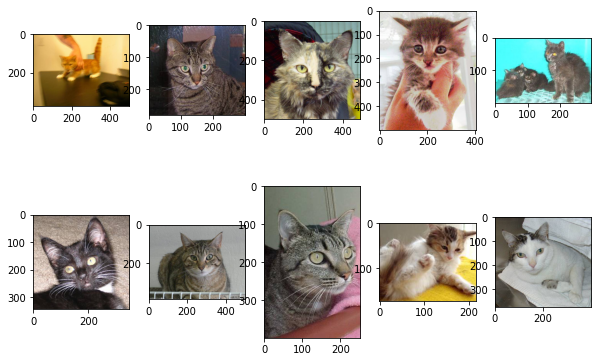

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

folder = "cats_and_dogs_filtered/train/cats/*"
files = glob.glob(folder)
files.sort()

print("total", len(files),"files!")

plt.figure(figsize=(10,10))
columns = 5
show_subset = 10

for i, img_path in enumerate(files[:show_subset]):
    image = mpimg.imread(img_path)
    print(img_path, "=", image.shape)

    plt.subplot(show_subset / columns + 1, columns, i + 1)
    plt.imshow(image)

# 1C Flowers dataset

In [ ]:
!wget http://download.tensorflow.org/example_images/flower_photos.tgz
!tar -zxf flower_photos.tgz
!rm flower_photos.tgz

--2022-02-16 22:51:34--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.63.128, 2607:f8b0:4004:806::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.63.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  60.6MB/s    in 3.6s    

2022-02-16 22:51:37 (60.6 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
!ls /content/flower_photos/

!mkdir /content/flower_photos/all
!cp /content/flower_photos/daisy/* /content/flower_photos/all/
!cp /content/flower_photos/roses/* /content/flower_photos/all/
!cp /content/flower_photos/sunflowers/* /content/flower_photos/all/
!cp /content/flower_photos/tulips/* /content/flower_photos/all/

# 1D Dataset made from video frames (Youtube)

In [ ]:
# get a youtube downloader
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     3  100     3    0     0      4      0 --:--:-- --:--:-- --:--:--     4
100     3  100     3    0     0      4      0 --:--:-- --:--:-- --:--:--     4
100   645  100   645    0     0    856      0 --:--:-- --:--:-- --:--:--   856
100 1794k  100 1794k    0     0  2218k      0 --:--:-- --:--:-- --:--:-- 2218k


In [ ]:
youtube_url = "https://www.youtube.com/watch?v=kMhrAw6xnW0" # shaky tree video

In [ ]:
# available formats?
!youtube-dl -F $youtube_url

[youtube] kMhrAw6xnW0: Downloading webpage
[youtube] kMhrAw6xnW0: Downloading MPD manifest
[info] Available formats for kMhrAw6xnW0:
format code  extension  resolution note
139          m4a        audio only DASH audio   49k , m4a_dash container, mp4a.40.5 (22050Hz), 732.55KiB
251          webm       audio only tiny   88k , webm_dash container, opus @ 88k (48000Hz), 1.30MiB
140          m4a        audio only tiny  129k , m4a_dash container, mp4a.40.2@129k (44100Hz), 1.90MiB
278          webm       256x144    DASH video   95k , webm_dash container, vp9, 24fps, video only
160          mp4        256x144    DASH video  108k , mp4_dash container, avc1.4d400b, 24fps, video only
242          webm       426x240    DASH video  220k , webm_dash container, vp9, 24fps, video only
133          mp4        426x240    DASH video  242k , mp4_dash container, avc1.4d400c, 24fps, video only
243          webm       640x360    DASH video  405k , webm_dash container, vp9, 24fps, video only
134          mp4 

In [ ]:
# Setting "134" for a 640x360 mp4 file
!youtube-dl -f 134 $youtube_url -o 'youtube_dataset.mp4'

[youtube] kMhrAw6xnW0: Downloading webpage
[youtube] kMhrAw6xnW0: Downloading MPD manifest
[download] Destination: youtube_dataset.mp4
[download] 100% of 9.27MiB in 03:04


In [ ]:
input_video = "youtube_dataset.mp4"
fps = 12 # sampling of the input
!mkdir video_frames
!ffmpeg -i $input_video -vf fps=$fps video_frames/%04d.jpg    # video 2 frames

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

total 1473 files!
video_frames/1169.jpg = (360, 640, 3)
video_frames/0475.jpg = (360, 640, 3)
video_frames/0727.jpg = (360, 640, 3)
video_frames/0072.jpg = (360, 640, 3)
video_frames/1001.jpg = (360, 640, 3)
video_frames/0998.jpg = (360, 640, 3)
video_frames/1283.jpg = (360, 640, 3)
video_frames/0570.jpg = (360, 640, 3)
video_frames/1063.jpg = (360, 640, 3)
video_frames/0363.jpg = (360, 640, 3)


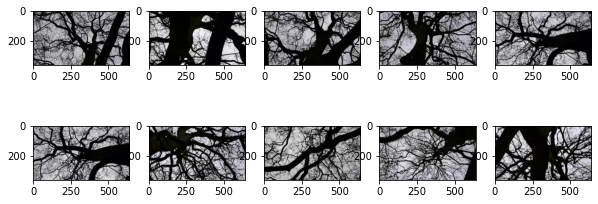

In [ ]:
import glob, random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

folder = "video_frames/*"
files = glob.glob(folder)
#files.sort()

print("total", len(files),"files!")
random.shuffle(files)

plt.figure(figsize=(10,6))
columns = 5
show_subset = 10

for i, img_path in enumerate(files[:show_subset]):
    image = mpimg.imread(img_path)
    print(img_path, "=", image.shape)

    plt.subplot(show_subset / columns + 1, columns, i + 1)
    plt.imshow(image)

# 2 process data

In [ ]:
# Choose your preference or plug in your own data

#my_data_lives_at = "/content/cats_and_dogs_filtered/train/cats/" # ~1000 photos
#my_data_lives_at = "/content/flower_photos/daisy/" # ~600 photos
#my_data_lives_at = "/content/flower_photos/all/" # ~2700 photos
my_data_lives_at = "/content/video_frames/" # ~1473 photos (at 12fps)


## Resize to the same sizes

In [ ]:
input_folder = my_data_lives_at
target_resized_folder = "/content/resized/"
resolution = 256

assert input_folder[-1] == "/" # end with /
assert target_resized_folder[-1] == "/"

import os
import cv2
from tqdm import tqdm
from PIL import Image, ImageOps


def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size, expected_size))
    # print(img.size)
    delta_width = expected_size - img.size[0]
    delta_height = expected_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def pad_resize_on_folder(input_folder, target_resized_folder):

  # input
  files = os.listdir(input_folder)
  
  # output
  if not os.path.exists(target_resized_folder):
      os.makedirs(target_resized_folder)

  print("processing", len(files), "images")

  resized = []
  for f in tqdm(files):
    img = Image.open(input_folder+f)
    resized_img = resize_with_padding(img,resolution)
    resized_img.save(target_resized_folder+f) 

pad_resize_on_folder(input_folder, target_resized_folder)

# Note: on some datasets, a central crop would be better...

processing 1473 images


100%|██████████| 1473/1473 [00:11<00:00, 132.38it/s]


## Use edge detector

Note that the original pix2pix paper was using a more advanced "image 2 edge" transform (namely [this one](https://github.com/s9xie/hed)), but it's a bit of pain to make run (uses python2 and older Caffe library) and quite slow.

We will use a simple Canny filter: https://en.wikipedia.org/wiki/Canny_edge_detector

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


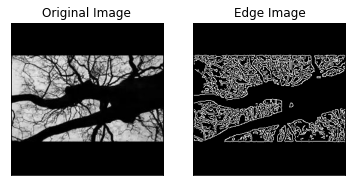

In [ ]:
# Edge detection with a simple Canny filter
# canny ~ https://en.wikipedia.org/wiki/Canny_edge_detector

import numpy as np
import cv2
from matplotlib import pyplot as plt
files = os.listdir("/content/resized/")

img = cv2.imread('/content/resized/'+files[0],0)
print(img)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
# Let's run it on the whole folder ...

%cd /content
input_folder = "/content/resized/"
target_edges_folder = "/content/edges/"

assert input_folder[-1] == "/" # end with /
assert target_edges_folder[-1] == "/"

import numpy as np
import cv2
import os
from tqdm import tqdm

def img2edge(img):
  return cv2.Canny(img,100,200)

def img2edge_on_folder(input_folder, target_edges_folder):

  # input
  files = os.listdir(input_folder)

  # output
  if not os.path.exists(target_edges_folder):
      os.makedirs(target_edges_folder)

  print("processing", len(files), "images")

  for f in tqdm(files):
    img = cv2.imread(input_folder+f,0)
    edge = img2edge(img)
    cv2.imwrite(target_edges_folder+f, edge) 

img2edge_on_folder(input_folder, target_edges_folder)

/content
processing 1473 images


100%|██████████| 1473/1473 [00:02<00:00, 541.97it/s]


## Combine images (for pix2pix)

In [ ]:
A_folder = "/content/resized/"
B_folder = "/content/edges/"
output_folder = "/content/combined/"
subset = None # we can select a subset here

if True:
    img_fold_A = os.path.join(A_folder)
    img_fold_B = os.path.join(B_folder)
    img_list = filter( lambda f: not f.startswith('.'), os.listdir(img_fold_A)) # ignore hidden folders like .DS_Store
    img_list = list(img_list)
    print("Will combine", len(img_list), "pairs")

    num_imgs = len(img_list)
    if subset is not None:
      num_imgs = min(subset, len(img_list))
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    for n in range(num_imgs):
        name_A = img_list[n]
        path_A = os.path.join(img_fold_A, name_A)
        name_B = name_A
        path_B = os.path.join(img_fold_B, name_B)

        if os.path.isfile(path_A) and os.path.isfile(path_B):
            name_AB = name_A
            path_AB = os.path.join(output_folder, name_AB)
            im_A = cv2.imread(path_A, cv2.IMREAD_COLOR)
            im_B = cv2.imread(path_B, cv2.IMREAD_COLOR)
            im_AB = np.concatenate([im_A, im_B], 1)
            cv2.imwrite(path_AB, im_AB)

Will combine 1473 pairs


In [ ]:
# Split into train/val set

import random
import glob
import os

def split(folder, train_frac=0.8, shuffle=True): 
    files = glob.glob(os.path.join(folder, "*.jpg"))
    files.sort()

    assignments = []
    assignments.extend(["train"] * int(train_frac * len(files)))
    assignments.extend(["val"] * int(len(files) - len(assignments)))

    if shuffle:
        random.shuffle(assignments)

    for name in ["train", "val", "test"]:
        if name in assignments:
            d = os.path.join(folder, name)
            if not os.path.exists(d):
                os.makedirs(d)

    print(len(files), len(assignments))
    for inpath, assignment in zip(files, assignments):
        outpath = os.path.join(folder, assignment, os.path.basename(inpath))
        #print(inpath, "->", outpath)
        os.rename(inpath, outpath)

split("/content/combined/")

1473 1473


In [ ]:
!ls /content/combined

train  val


# 3 train pix2pix

## Configuration and imports

In [ ]:
%cd /content/

import os
os.environ['KERAS_BACKEND']='tensorflow'
import keras.backend as K
K.set_image_data_format('channels_last')
channel_axis=-1
channel_first = False

from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

/content


Using TensorFlow backend.


## Generator and Discriminator:

In [ ]:
# Weights initializations
# bias are initailized as 0
conv_init = RandomNormal(0, 0.02) #  # for convolution kernel
gamma_init = RandomNormal(1., 0.02) # for batch normalization

# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

def BASIC_D(nc_in, nc_out, ndf, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a, input_b =  Input(shape=(nc_in, None, None)), Input(shape=(nc_out, None, None))
    else:
        input_a, input_b = Input(shape=(None, None, nc_in)), Input(shape=(None, None, nc_out))
    _ = Concatenate(axis=channel_axis)([input_a, input_b])
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_)

In [ ]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>8:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

channels_in = 3   # number of input channels ~ for RGB images 3
channels_out = 3  # number of output channels
generator_features = 64    # generator feature
discriminator_features = 64    # discriminator feature

loadSize = 286
imageSize = 256   # resolution of the loaded images

netD = BASIC_D(channels_in, channels_out, discriminator_features)
#netD.summary()

netG = UNET_G(imageSize, channels_in, channels_out, generator_features)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
#netG.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
from keras.optimizers import RMSprop, SGD, Adam

real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])
real_B = netD.inputs[1]
output_D_real = netD([real_A, real_B])
output_D_fake = netD([real_A, fake_B])


#loss_fn = lambda output, target : K.mean(K.binary_crossentropy(output, target))
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))

loss_L1 = K.mean(K.abs(fake_B-real_B))

lrD = 2e-4
lrG = 2e-4

# Loss Discriminator
loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_D/2], training_updates)

# Loss Generator
loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)

## Dataset loading:

In [ ]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))
    
def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    im = im.resize( (loadSize*2, loadSize), Image.BILINEAR )
    arr = np.array(im).astype(float)
    arr=arr/255*2-1
    #arr = np.array(im)
    w1,w2 = int((loadSize-imageSize)/2),int((loadSize+imageSize)/2)
    h1,h2 = int(w1),int(w2)
    #print(w1,w2,h1,h2)
    imgA = arr[h1:h2, loadSize+w1:loadSize+w2, :]
    imgB = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        imgA=imgA[:,::-1]
        imgB=imgB[:,::-1]
    if channel_first:
        imgA = np.moveaxis(imgA, 2, 0)
        imgB = np.moveaxis(imgB, 2, 0)
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

In [ ]:
"""
#Option if we loaded data from 1A
data = "facades"
direction = 0
trainAB = load_data('datasets/{}/train/*.jpg'.format(data))
valAB = load_data('datasets/{}/val/*.jpg'.format(data))
"""

#Option if we used our own data from 1B,1C,1D

data = "edges2images"
direction = 0
trainAB = load_data('/content/combined/train/*.jpg')
valAB = load_data('/content/combined/val/*.jpg')

assert len(trainAB) and len(valAB)

print("Loaded dataset:", data)
print(len(trainAB), "images in training set,", len(valAB), "images in validation set")

imgA,imgB = read_image(trainAB[0], direction=0)
print("sample image pair: A:",imgA.shape, ", B:", imgB.shape)

Loaded dataset: edges2images
1178 images in training set, 295 images in validation set
sample image pair: A: (256, 256, 3) , B: (256, 256, 3)


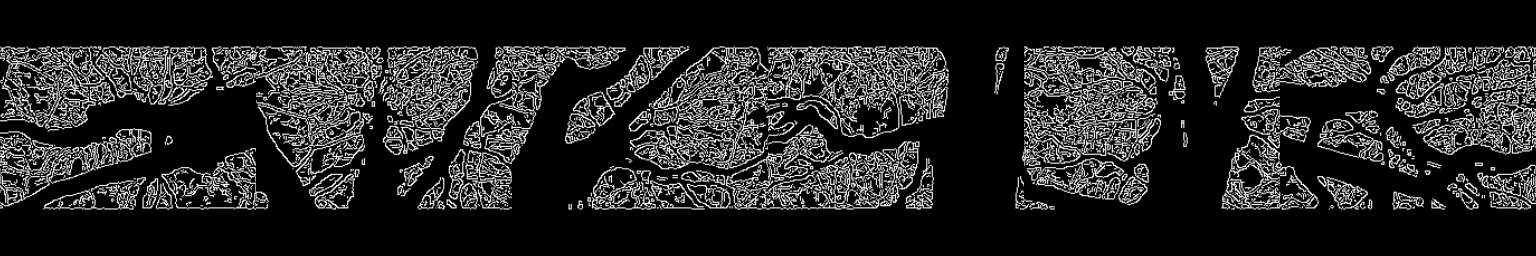

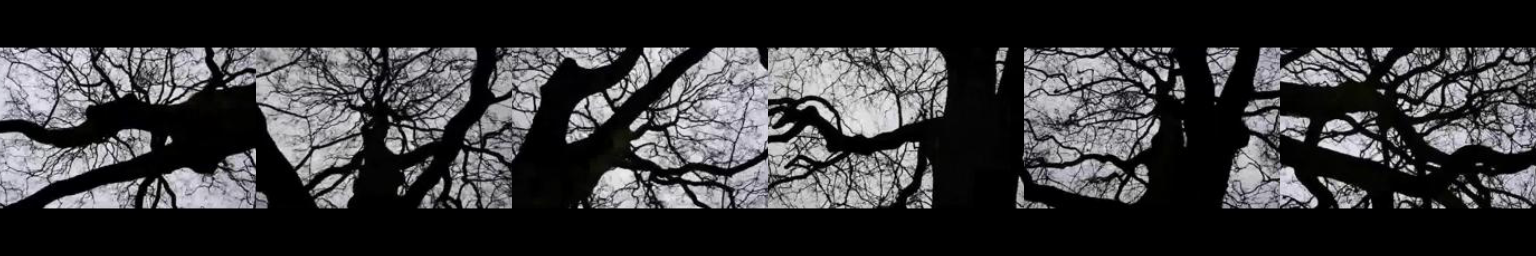

In [ ]:
# Let's look at 6 random samples:

train_batch = minibatch(trainAB, 6, direction=0)
_, trainA, trainB = next(train_batch)
showX(trainA)
showX(trainB)

## Training:

*(keeps last few outputs in the log)*

In [ ]:
number_of_epochs = 100    ### number of epochs  # 10 is enough for first demos
batchSize = 128           ### batch size ~ how many images are loaded in the memory at the same time
                          # Note: you will probably need to lower this number on your own PCs...
                          # 128 was the max I got out of Colab
  
# notes from training with flowers/daisies
# - until around 15 epochs gets white ghosty like shapes, mostly just white and green
# - after 30 we get yellows
# - after 44 suddenly blues ~


# notes on cats
# - around 7th epoch we have only blurry mostly brown-gray images
# - at 15 we get some orange ~
# - even at 50 it's pretty messy and busy
# - around 65 it is starting to look ok-ish, bit better around 85
# - 100 epochs, somewhat real colors but a lot of square artifacts
# - 150 looks ok

# notes from training on all flower images (~ 2700 photos)
# - (will take more time ...)

# notes from training on the tree video
# - somewhat reasonable even after 10 epochs (very low resolution / quality, but nice abstraction perhaps...)
# - 15ep, smaller twigs begin to show
# - 25ep, grid artifacts show up, they keep up until around 40ep 
# - 80ep, the artifacts have mostly cleaned up, actually pretty nice



In [ ]:
import time
from IPython.display import clear_output
t0 = time.time()
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = int(500 / batchSize)   ### How often should we visualize output
val_batch = minibatch(valAB, 6, direction)
train_batch = minibatch(trainAB, batchSize, direction)

def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

while epoch < number_of_epochs: 
    epoch, trainA, trainB = next(train_batch)        
    errD,  = netD_train([trainA, trainB])
    errD_sum +=errD

    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, number_of_epochs, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        

Inference:

In [ ]:
_, valA, valB = train_batch.send(6) 
fakeB = netG_gen(valA)
showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
errL1_sum = errG_sum = errD_sum = 0
_, valA, valB = next(val_batch)
fakeB = netG_gen(valA)
showX(np.concatenate([valA, valB, fakeB], axis=0), 3)

## Optionally save/load the models:



In [ ]:
if True: #False
  # Save netG and netD
  print(netG)
  print(netD)

  %cd /content/
  netG.save_weights('last_netG_w.h5')
  netD.save_weights('last_netD_w.h5')

/content


In [ ]:
if False: 
  # Or load from an older saved model

  # uncomment one:
  #!gdown https://drive.google.com/uc?id=1N2LvgfyRAJYEPpc352og24UzBrCdcJgn # cats 
  #netG.load_weights('cats_netG_w.h5')

  #!gdown https://drive.google.com/uc?id=1KulS1urm2qs2FZFG4y4I9w2in2zMTHi5 # flowers 50 epochs 
  #netG.load_weights('flowers50ep_netG_w.h5')


# 4 Inference, using the pix2pix model

(1, 256, 256, 3)
(1, 256, 256, 3)


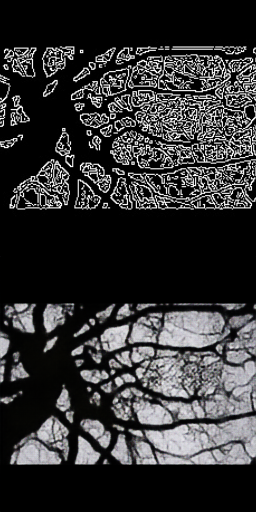

In [ ]:
# One image:
_, inputImage, _ = train_batch.send(1)
print(inputImage.shape)

output = netG.predict(inputImage)
print(output.shape)
showX(np.concatenate([inputImage, output], axis=0), 2)

## ... from random noise?

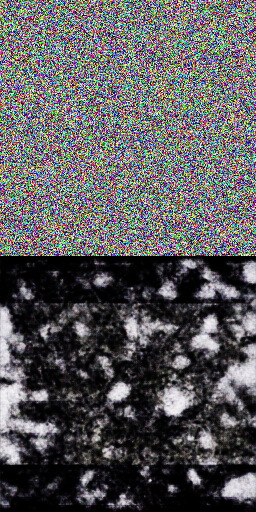

In [ ]:
# Random noise:
import numpy as np
how_many_samples = 1
random_noise = np.random.randn(how_many_samples, 256, 256, 3)

generatedImage = netG.predict(random_noise)
showX(np.concatenate([random_noise, generatedImage], axis=0), 2)

## ... from image of other dataset?

We can also try the model with images that are not from our dataset ... we must remember to apply all the transforms in the same manner as we did with the data in the training dataset.

In [ ]:
import cv2
import numpy as np

#imposter = "/content/cats_and_dogs_filtered/validation/dogs/dog.2002.jpg"
imposter = "/content/flower_photos/tulips/3449794006_8c289840aa.jpg"

img = cv2.imread(imposter,0)
edge = img2edge(img)
cv2.imwrite("test.jpg", edge)
pass

(256, 256, 3)


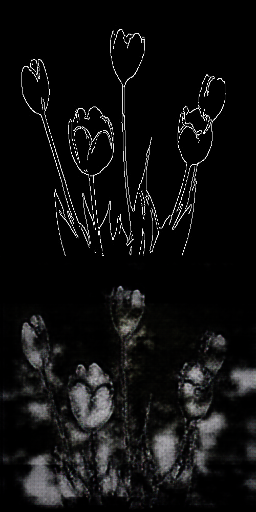

In [ ]:
img = cv2.imread("test.jpg")
res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
res = res/255*2-1

print(res.shape)

loaded_image = np.reshape(res, (1, 256, 256, 3))

generatedImage = netG.predict(loaded_image)
showX(np.concatenate([loaded_image, generatedImage], axis=0), 2)

--2022-02-16 22:52:33--  https://distill.pub/2017/aia/images/bread-cat-input.jpg
Resolving distill.pub (distill.pub)... 151.101.65.195, 151.101.1.195
Connecting to distill.pub (distill.pub)|151.101.65.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38168 (37K) [image/jpeg]
Saving to: ‘bread-cat-input.jpg’

bread-cat-input.jpg 100%[===================>]  37.27K  --.-KB/s    in 0s      

2022-02-16 22:52:33 (131 MB/s) - ‘bread-cat-input.jpg’ saved [38168/38168]

(256, 256, 3)


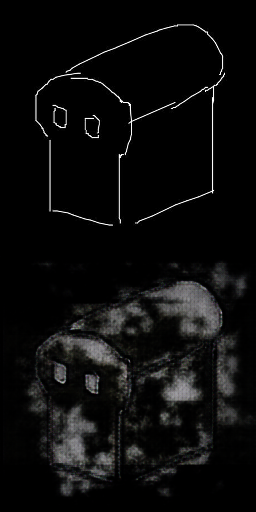

In [ ]:
# Get a test image ...
# ... note that this is already in the edges representation ...
!wget https://distill.pub/2017/aia/images/bread-cat-input.jpg

img = cv2.imread("bread-cat-input.jpg")
img = (255-img) # invert it
res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
res = res/255*2-1

print(res.shape)

loaded_image = np.reshape(res, (1, 256, 256, 3))

generatedImage = netG.predict(loaded_image)
showX(np.concatenate([loaded_image, generatedImage], axis=0), 2)

## ... from random lines?

(256, 256, 3)


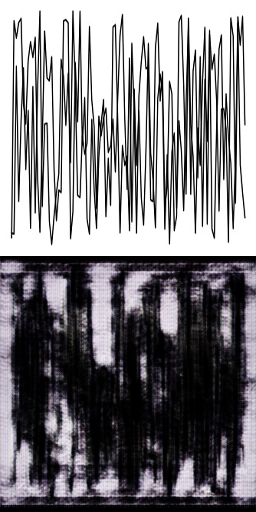

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
how_many = 100

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
plt.axis('off')

x = np.random.uniform(0, 100, how_many)
y  = np.random.uniform(0, 100, how_many)
xy = list(zip(x, y))

#ax.set_facecolor('black')
plt.plot(xy, color='black')

extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('plt.jpg', bbox_inches=extent)
plt.close()

#### Then use pix2pix

img = cv2.imread("plt.jpg")
res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
res = res/255*2-1

print(res.shape)

loaded_image = np.reshape(res, (1, 256, 256, 3))

generatedImage = netG.predict(loaded_image)
showX(np.concatenate([loaded_image, generatedImage], axis=0), 2)

## ... from a random generated tree?

--2022-02-16 22:52:45--  https://pythoninformer.com/img/generative-art/grammars/lsystem-fern.png
Resolving pythoninformer.com (pythoninformer.com)... 104.248.242.4
Connecting to pythoninformer.com (pythoninformer.com)|104.248.242.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67782 (66K) [image/png]
Saving to: ‘lsystem-fern.png’

lsystem-fern.png    100%[===================>]  66.19K   367KB/s    in 0.2s    

2022-02-16 22:52:45 (367 KB/s) - ‘lsystem-fern.png’ saved [67782/67782]

(256, 256, 3)


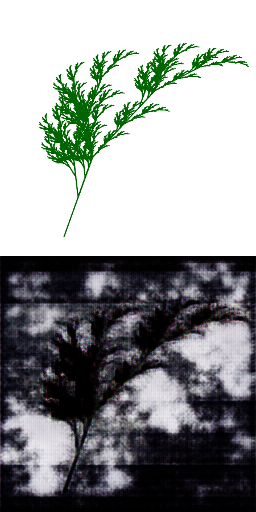

In [ ]:
# Get a test image ...
!wget https://pythoninformer.com/img/generative-art/grammars/lsystem-fern.png
# note: this one was also generated as a l system ... could be quite cool to plug that in maybe ... but here just as a demo :)

img = cv2.imread("lsystem-fern.png")
#img = (255-img) # invert it
res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
res = res/255*2-1

print(res.shape)

loaded_image = np.reshape(res, (1, 256, 256, 3))

generatedImage = netG.predict(loaded_image)
showX(np.concatenate([loaded_image, generatedImage], axis=0), 2)



From a short snippet that draws random generated trees:

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycairo: filename=pycairo-1.20.1-cp37-cp37m-linux_x86_64.whl size=244743 sha256=85d8fa7a5d20bea60588316fbbbaad7cf3f11ec4271e44acb6087b1b929ff88d
  Stored in directory: /root/.cache/pip/wheels/0f/a7/3d/d8d8e8bd0cfe5cfb9059ccdd9fb6e0130e65c5a5dac41cc881
Successfully built pycairo


In [ ]:
"""
From => pretty cool repo https://github.com/gaw1ik/Generative-Art-In-Python-Branching-Trees
"""

#%% IMPORT
from IPython import get_ipython
#get_ipython().magic('reset -sf')

import numpy as np
import math as m
import cairo
from random import choice, random
import random
from skimage.io import imshow

def draw_random_tree(pixel_scale = 256, nBranches = 4, maxBranchLengths_n = 0.6, branchThickness = 0.05, angleChange = 20):
    ''' Image Options '''
    s = 1
    
    bc = (0,0,0) # Background color

    ''' Trunk Options '''
    x1, y1 = 0,0 # Trunk start position

    ''' Color Options '''
    rgbColor = (255,255,255) # Color of branches

    ''' Branch Options '''
    
    xarr = np.zeros([nBranches])
    for i in range(nBranches): xarr[i] = i+1
    maxBranchLengths = maxBranchLengths_n**xarr
    rarity = 5
    angleChange = 20

    # Cairo surface stuff
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, s*pixel_scale, s*pixel_scale)
    ctx = cairo.Context(surface)
    ctx.set_source_rgb(bc[0],bc[1],bc[2])
    ctx.paint()
    ctx.scale(pixel_scale, pixel_scale)  # Normalize the canvas

    branches = [[] for i in range(nBranches+1)]

    branches[0].append([x1,y1,0])

    # Draw branches
    for i in range(nBranches):
        
        for branchpoint in branches[i]:
            x1,y1 = branchpoint[0],branchpoint[1]
            thetad = branchpoint[2] + angleChange
            
            ctx.move_to(x1,y1)
            
            branchLength = 0
            
            while (branchLength < maxBranchLengths[i]):
                h = choice([0.01,0.02,0.03])
                thetad = thetad + random.randrange(-10,10)
                theta = m.radians(thetad)
                x2 = h*m.cos(theta) + x1
                y2 = h*m.sin(theta) + y1

                ctx.line_to(x2,y2)
                branchLength = branchLength + h
                
                x1,y1 = x2,y2 # Reset
                
                # Branch decision
                if (choice([0]*rarity + [1])==1 and branchLength < 0.8*maxBranchLengths[i]):
                    branches[i+1].append((x2,y2,thetad))
                    
            # Draws the branch
            ctx.set_source_rgb(rgbColor[0],rgbColor[1], rgbColor[2])
            ctx.set_line_width(branchThickness)
            ctx.stroke()

    #%% Plot the image
            
    ## Convert to numpy array 
    buf = surface.get_data()
    I = np.ndarray(shape=(s*pixel_scale, s*pixel_scale),dtype=np.uint32,buffer=buf)

    return I

(4, 256, 256, 3)


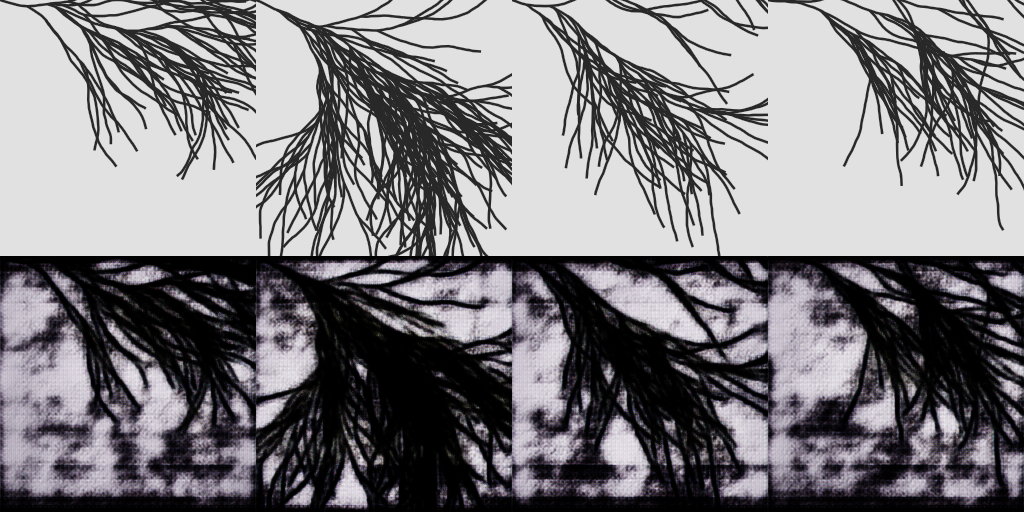

In [ ]:
def one_tree():
    #draw_random_tree(pixel_scale = 256, nBranches = 4, maxBranchLengths_n = 0.6, branchThickness = 0.05, angleChange = 20)
    I = draw_random_tree(maxBranchLengths_n = 0.8, angleChange = 45, branchThickness = 0.01)

    from PIL import Image
    plt.imsave('randomtree.png', I)

    img = cv2.imread("randomtree.png")
    img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
    img = (255-img) # invert it
    res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    res = res/255*2-1
    return res

res = []
for i in range(4):
  res.append(one_tree())

res = np.asarray(res)
print(res.shape)

loaded_image = np.reshape(res, (len(res), 256, 256, 3))

generatedImage = netG.predict(loaded_image)
showX(np.concatenate([loaded_image, generatedImage], axis=0), 2)


# (bonus) copy models to your drive

In [ ]:
assert False
# Don't continue even if we started with a "run all" command

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir /content/gdrive/MyDrive/SavedModels

In [ ]:
# back up the models
!cp *.h5 /content/gdrive/MyDrive/SavedModels/

In [ ]:
!ls /content/gdrive/MyDrive/SavedModels/

In [ ]:
# or load them back with
# !cp /content/gdrive/MyDrive/SavedModels/*.h5 /content/

# (Bonus) Edit a video with the pix2pix model

However note that the quality can be quite low ...

Check out a version with a model that trained +- 20 epochs here: https://www.youtube.com/watch?v=xDrIjyzavog



In [ ]:
# get a youtube downloader
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

# note: youtube-dl is slow lately ... there's a more experimental build yt-dlp (but idk for how long would that be kept up to date ... in any case leaving this as a note here)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     3    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     3    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   614  100   614    0     0    599      0  0:00:01  0:00:01 --:--:--   599
100 1781k  100 1781k    0     0  1654k      0  0:00:01  0:00:01 --:--:-- 1654k


In [ ]:
youtube_url = "https://www.youtube.com/watch?v=atyvdC15HFA" # train ride in everloving

In [ ]:
!youtube-dl -F $youtube_url -o 'youtube_input.mp4'

In [ ]:
# full video resolution is actually not needed for what we will be doing...
#!youtube-dl -f 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4' $youtube_url -o 'youtube_input.mp4'
!youtube-dl -f 134 $youtube_url -o 'youtube_input.mp4'

[youtube] atyvdC15HFA: Downloading webpage
[youtube] atyvdC15HFA: Downloading player 41de1c08
[download] Destination: youtube_input.mp4
[download] 100% of 21.70MiB in 07:59


In [ ]:
def frame_edit(frame):
  img = Image.open(frame)
  resized_img = resize_with_padding(img,resolution)
  
  # Convert RGB to BGR 
  open_cv_image = np.array(resized_img)[:, :, ::-1].copy() 
  gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
  img = gray

  edge = img2edge(img)
  img = cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)

  res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
  res = res/255*2-1
  #print(res.shape)
  loaded_image = np.reshape(res, (1, 256, 256, 3))
  generatedImage = netG.predict(loaded_image)
  #print(generatedImage.shape)

  X = generatedImage
  int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
  if channel_first:
      int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
  else:
      int_X = int_X.reshape(-1,imageSize,imageSize, 3)

  return int_X[0]

def model_on_folder(input_folder="video_tmp/", target_edges_folder="video_transformed/"):

  # input
  files = os.listdir(input_folder)

  # output
  if not os.path.exists(target_edges_folder):
      os.makedirs(target_edges_folder)

  print("processing", len(files), "images")

  for f in tqdm(files):
    generated = frame_edit(input_folder+f)
    cv2.imwrite(target_edges_folder+f, generated) 


In [ ]:
input_video = "youtube_input.mp4"
fps = 2 # sampling of the input
fps = 12 # < want it more smooth ?
!mkdir video_tmp
#!ffmpeg -i $input_video -vf fps=$fps video_tmp/%04d.jpg    # video 2 frames

# With -t [duration] in seconds
!ffmpeg -i $input_video -t 120 -vf fps=$fps video_tmp/%04d.jpg    # video 2 frames

model_on_folder(input_folder="video_tmp/", target_edges_folder="video_transformed/")    # ~ do the magic here

fps = fps # output's fps
!ffmpeg -r $fps/1 -i video_transformed/%04d.jpg -c:v libx264 -vf fps=$fps -pix_fmt yuv420p output.mp4     # frames 2 video

print("finished and generated - output.mp4")
!ls -luah *.mp4

In [ ]:
!cp output.mp4 /content/gdrive/MyDrive/SavedModels/

In [ ]:
# to restart delete the intermediate files:
!rm video_transformed -dr
!rm video_tmp -dr
!rm output.mp4

### (trying on itself)

In [ ]:
input_video = "youtube_dataset.mp4"
fps = 24 #
!mkdir video_tmp_itself
!ffmpeg -i $input_video -vf fps=$fps video_tmp_itself/%04d.jpg    # video 2 frames

model_on_folder(input_folder="video_tmp_itself/", target_edges_folder="video_transformed_itself/")    # ~ do the magic here

fps = fps # output's fps
!ffmpeg -r $fps/1 -i video_transformed_itself/%04d.jpg -c:v libx264 -vf fps=$fps -pix_fmt yuv420p output_on_itself.mp4     # frames 2 video

print("finished and generated - output_on_itself.mp4")
!ls -luah *.mp4

## even view it here

In [ ]:
!pip install -U kora

In [ ]:
# note: this one will upload the video into your drive home folder and then embed here in the notebook...

from kora.drive import upload_public
url = upload_public('output.mp4')
# then display it
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")